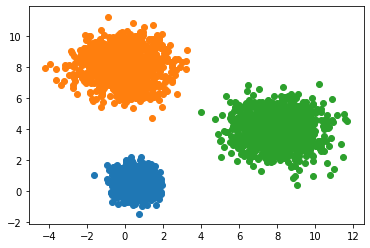

In [1]:
# 导入第三方包
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics

# 随机生成三组二元正态分布随机数 
np.random.seed(1234)
mean1 = [0.5, 0.5]
cov1 = [[0.3, 0], [0, 0.3]]
x1, y1 = np.random.multivariate_normal(mean1, cov1, 1000).T

mean2 = [0, 8]
cov2 = [[1.5, 0], [0, 1]]
x2, y2 = np.random.multivariate_normal(mean2, cov2, 1000).T

mean3 = [8, 4]
cov3 = [[1.5, 0], [0, 1]]
x3, y3 = np.random.multivariate_normal(mean3, cov3, 1000).T

# 绘制三组数据的散点图
plt.scatter(x1,y1)
plt.scatter(x2,y2)
plt.scatter(x3,y3)
# 显示图形
plt.show()

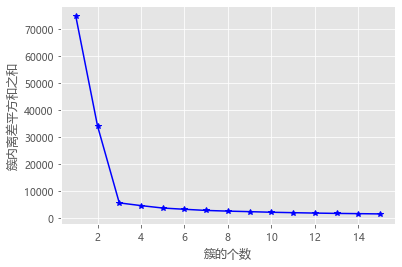

In [2]:
# 构造自定义函数，用于绘制不同k值和对应总的簇内离差平方和的折线图
def k_SSE(X, clusters):
    # 选择连续的K种不同的值
    K = range(1,clusters+1)
    # 构建空列表用于存储总的簇内离差平方和
    TSSE = []
    for k in K:
        # 用于存储各个簇内离差平方和
        SSE = []
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        # 返回簇标签
        labels = kmeans.labels_
        # 返回簇中心
        centers = kmeans.cluster_centers_
        # 计算各簇样本的离差平方和，并保存到列表中
        for label in set(labels):
            SSE.append(np.sum((X.loc[labels == label,]-centers[label,:])**2))
        # 计算总的簇内离差平方和 
        TSSE.append(np.sum(SSE))

    # 中文和负号的正常显示
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False
    # 设置绘图风格
    plt.style.use('ggplot')
    # 绘制K的个数与GSSE的关系
    plt.plot(K, TSSE, 'b*-')
    plt.xlabel('簇的个数')
    plt.ylabel('簇内离差平方和之和')
    # 显示图形
    plt.show()

# 将三组数据集汇总到数据框中
X = pd.DataFrame(np.concatenate([np.array([x1,y1]),np.array([x2,y2]),np.array([x3,y3])], axis = 1).T)
# 自定义函数的调用
k_SSE(X, 15)

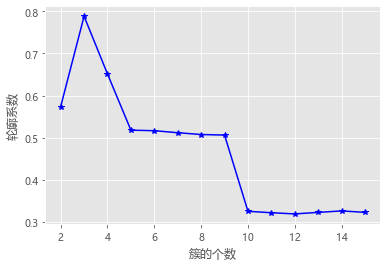

In [3]:
# 构造自定义函数，用于绘制不同k值和对应轮廓系数的折线图
def k_silhouette(X, clusters):
    K = range(2,clusters+1)
    # 构建空列表，用于存储个中簇数下的轮廓系数
    S = []
    for k in K:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        labels = kmeans.labels_
        # 调用字模块metrics中的silhouette_score函数，计算轮廓系数
        S.append(metrics.silhouette_score(X, labels, metric='euclidean'))

    # 中文和负号的正常显示
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False
    # 设置绘图风格
    plt.style.use('ggplot')    
    # 绘制K的个数与轮廓系数的关系
    plt.plot(K, S, 'b*-')
    plt.xlabel('簇的个数')
    plt.ylabel('轮廓系数')
    # 显示图形
    plt.show()
    
# 自定义函数的调用
k_silhouette(X, 15)

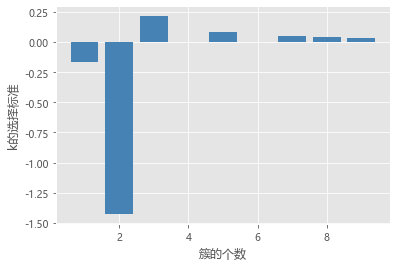

In [4]:
# 自定义函数，计算簇内任意两样本之间的欧氏距离
def short_pair_wise_D(each_cluster):
    mu = each_cluster.mean(axis = 0)
    Dk = sum(sum((each_cluster - mu)**2)) * 2.0 * each_cluster.shape[0]
    return Dk

# 计算簇内的Wk值
def compute_Wk(data, classfication_result):
    Wk = 0
    label_set = set(classfication_result)
    for label in label_set:
        each_cluster = data[classfication_result == label, :]
        Wk = Wk + short_pair_wise_D(each_cluster)/(2.0*each_cluster.shape[0])
    return Wk

# 计算GAP统计量 
def gap_statistic(X, B=10, K=range(1,11), N_init = 10):
    # 将输入数据集转换为数组
    X = np.array(X)
    # 生成B组参照数据
    shape = X.shape
    tops = X.max(axis=0)
    bots = X.min(axis=0)
    dists = np.matrix(np.diag(tops-bots))
    rands = np.random.random_sample(size=(B,shape[0],shape[1]))
    for i in range(B):
        rands[i,:,:] = rands[i,:,:]*dists+bots
    
    # 自定义0元素的数组，用于存储gaps、Wks和Wkbs
    gaps = np.zeros(len(K))
    Wks = np.zeros(len(K))
    Wkbs = np.zeros((len(K),B))
    # 循环不同的k值，
    for idxk, k in enumerate(K):
        k_means =  KMeans(n_clusters=k)
        k_means.fit(X)
        classfication_result = k_means.labels_
        # 将所有簇内的Wk存储起来
        Wks[idxk] = compute_Wk(X,classfication_result)
        
        # 通过循环，计算每一个参照数据集下的各簇Wk值
        for i in range(B):
            Xb = rands[i,:,:]
            k_means.fit(Xb)
            classfication_result_b = k_means.labels_
            Wkbs[idxk,i] = compute_Wk(Xb,classfication_result_b)

    # 计算gaps、sd_ks、sk和gapDiff
    gaps = (np.log(Wkbs)).mean(axis = 1) - np.log(Wks)        
    sd_ks = np.std(np.log(Wkbs), axis=1)
    sk = sd_ks*np.sqrt(1+1.0/B)
    # 用于判别最佳k的标准，当gapDiff首次为正时，对应的k即为目标值
    gapDiff = gaps[:-1] - gaps[1:] + sk[1:]
    
    # 中文和负号的正常显示
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False
    # 设置绘图风格
    plt.style.use('ggplot')
    # 绘制gapDiff的条形图
    plt.bar(np.arange(len(gapDiff))+1, gapDiff, color = 'steelblue')
    plt.xlabel('簇的个数')
    plt.ylabel('k的选择标准')
    plt.show()
    
# 自定义函数的调用
gap_statistic(X)    

In [5]:
# 读取iris数据集
iris = pd.read_csv(r'iris.csv')
# 查看数据集的前几行
iris.head()

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [6]:
# 提取出用于建模的数据集X
X = iris.drop(labels = 'Species', axis = 1)
# 构建Kmeans模型
kmeans = KMeans(n_clusters = 3)
kmeans.fit(X)
# 聚类结果标签
X['cluster'] = kmeans.labels_
# 各类频数统计
X.cluster.value_counts()

0    62
1    50
2    38
Name: cluster, dtype: int64

In [7]:
iris.Species.value_counts()

versicolor    50
setosa        50
virginica     50
Name: Species, dtype: int64

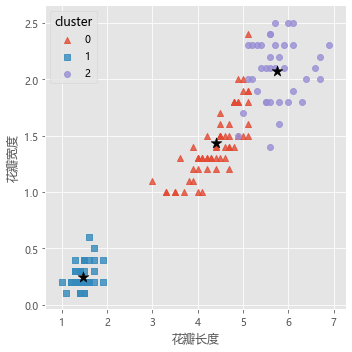

In [8]:
# 导入第三方模块
import seaborn as sns

# 三个簇的簇中心
centers = kmeans.cluster_centers_
# 绘制聚类效果的散点图
sns.lmplot(x = 'Petal_Length', y = 'Petal_Width', hue = 'cluster', markers = ['^','s','o'], 
           data = X, fit_reg = False, scatter_kws = {'alpha':0.8}, legend_out = False)
plt.scatter(centers[:,2], centers[:,3], marker = '*', color = 'black', s = 130)
plt.xlabel('花瓣长度')
plt.ylabel('花瓣宽度')
# 图形显示
plt.show()

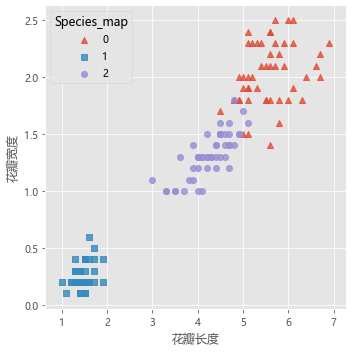

In [9]:
# 增加一个辅助列，将不同的花种映射到0,1,2三种值，目的方便后面图形的对比
iris['Species_map'] = iris.Species.map({'virginica':0,'setosa':1,'versicolor':2})
# 绘制原始数据三个类别的散点图
sns.lmplot(x = 'Petal_Length', y = 'Petal_Width', hue = 'Species_map', data = iris, markers = ['^','s','o'],
           fit_reg = False, scatter_kws = {'alpha':0.8}, legend_out = False)
plt.xlabel('花瓣长度')
plt.ylabel('花瓣宽度')
# 图形显示
plt.show()

In [10]:
# 导入第三方模块
import pygal
# 调用Radar这个类，并设置雷达图的填充，及数据范围
radar_chart = pygal.Radar(fill = True)
# 添加雷达图各顶点的名称
radar_chart.x_labels = ['花萼长度','花萼宽度','花瓣长度','花瓣宽度']

# 绘制三个雷达图区域，代表三个簇中心的指标值
radar_chart.add('C1', centers[0])
radar_chart.add('C2', centers[1])
radar_chart.add('C3', centers[2])
# 保存图像
radar_chart.render_to_file('radar_chart1.svg')

In [11]:
# 读取球员数据
players = pd.read_csv(r'players.csv')
players.head()

,排名,球员,球队,得分,命中-出手,命中率,命中-三分,三分命中率,命中-罚球,罚球命中率,场次,上场时间
0,1,詹姆斯-哈登,火箭,31.9,9.60-21.10,0.454,4.20-10.70,0.397,8.50-9.90,0.861,30,36.1
1,2,扬尼斯-阿德托昆博,雄鹿,29.7,10.90-19.90,0.545,0.50-1.70,0.271,7.50-9.80,0.773,28,38.0
2,3,勒布朗-詹姆斯,骑士,28.2,10.80-18.80,0.572,2.10-5.10,0.411,4.50-5.80,0.775,32,37.3
3,4,斯蒂芬-库里,勇士,26.3,8.30-17.60,0.473,3.60-9.50,0.381,6.00-6.50,0.933,23,32.6
4,4,凯文-杜兰特,勇士,26.3,9.70-19.00,0.510,2.50-6.30,0.396,4.50-5.10,0.879,26,34.8


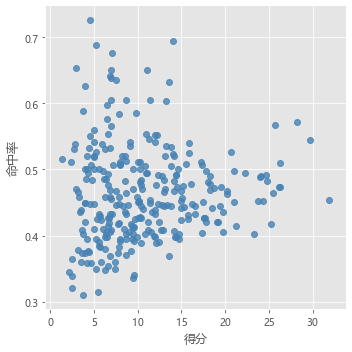

In [12]:
# 绘制得分与命中率的散点图
sns.lmplot(x = '得分', y = '命中率', data = players, 
           fit_reg = False, scatter_kws = {'alpha':0.8, 'color': 'steelblue'})
plt.show()

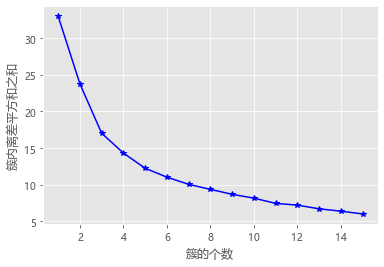

In [13]:
from sklearn import preprocessing
# 数据标准化处理
X = preprocessing.minmax_scale(players[['得分','罚球命中率','命中率','三分命中率']])
# 将数组转换为数据框
X = pd.DataFrame(X, columns=['得分','罚球命中率','命中率','三分命中率'])
# 使用拐点法选择最佳的K值
k_SSE(X, 15)

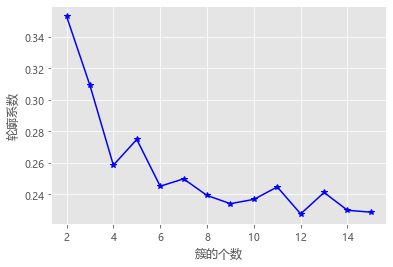

In [14]:
# 使用轮廓系数选择最佳的K值
k_silhouette(X, 15)

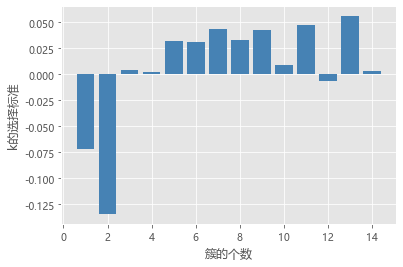

In [15]:
# 使用间隙统计量选择最佳的K值
gap_statistic(X, B = 20, K=range(1, 16))

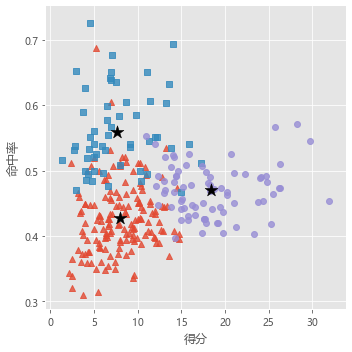

In [16]:
# 将球员数据集聚为3类
kmeans = KMeans(n_clusters = 3)
kmeans.fit(X)
# 将聚类结果标签插入到数据集players中
players['cluster'] = kmeans.labels_
# 构建空列表，用于存储三个簇的簇中心
centers = []
for i in players.cluster.unique():
    centers.append(players.loc[players.cluster == i,['得分','罚球命中率','命中率','三分命中率']].mean())
# 将列表转换为数组，便于后面的索引取数
centers = np.array(centers)

# 绘制散点图
sns.lmplot(x = '得分', y = '命中率', hue = 'cluster', data = players, markers = ['^','s','o'],
           fit_reg = False, scatter_kws = {'alpha':0.8}, legend = False)
# 添加簇中心
plt.scatter(centers[:,0], centers[:,2], c='k', marker = '*', s = 180)
plt.xlabel('得分')
plt.ylabel('命中率')
# 图形显示
plt.show()

In [17]:
# 雷达图
# 调用模型计算出来的簇中心
centers_std = kmeans.cluster_centers_
# 设置填充型雷达图
radar_chart = pygal.Radar(fill = True)
# 添加雷达图各顶点的名称
radar_chart.x_labels = ['得分','罚球命中率','命中率','三分命中率']

# 绘制雷达图代表三个簇中心的指标值
radar_chart.add('C1', centers_std[0])
radar_chart.add('C2', centers_std[1])
radar_chart.add('C3', centers_std[2])
# 保存图像
radar_chart.render_to_file('radar_chart2.svg')